<a href="https://colab.research.google.com/github/luciainnocenti/German-Credit-Data/blob/master/MML_Tesina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is about the analysis of credit risks of German Credit Data.
The dataset is [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).
It is composed by 1000 instances, each one defined by twenty attributes (both numerical and categorical).

The data are collected in 1994 and the last attribute referred to how the client has been categorized: good or bad credit risk.



# Imports



1.   **Files**: needed to upload the file directly from an external source
2.   **Pandas**: needed for manage data as matrices or vectors; provide many usefull function and especially the structure of Dataframe
3.  **Numpy**: needed for manage data as matrices or vectors; 
4.  **Pyplot** and **Seaborn**: useful for visualizations


In [1]:
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

#Import classification methods and support methods
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Import Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

SEED = 42

In [2]:
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['data.csv']), sep=';', header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2


# Data Exploration

In order to better define how the dataset is done, let's see some characteristics of features and data.
First, I have to rename all the columns because the original dataset haven't the header. So, starting from the description available in the original page, the resulting dataset is:

In [4]:
df.columns = ['checkingAccount','duration','creditHistory', 'purpose', 'creditAmount','savingsAcc','employmentTime', 'installmentPercIncome', 
              'status', 'otherFin', 'timeResidence', 'property' ,'age', 'otherInstallPlans' ,'housing' ,'numCredits', 'job', 'numOfMant', 'phone', 'foreignWorker', 'risk']
df['risk'] = df['risk'] - 1 #(0 = Good, 1 = Bad)
df.head(2)

,checkingAccount,duration,creditHistory,purpose,creditAmount,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,timeResidence,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker,risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,1


The description says that the dataset does not allow for null values. Let's check it:

In [5]:
df.isnull().values.any()

False

In [6]:
df['risk'] = df['risk'].astype('category')

## Numerical Data

The dataset is composed both from numerical and categorical attributes.

It is possbile to analize numerical ones by using the method describe, which print the following stats:


*   **Count** the total number of instances
*   **Mean** of all the instances
*   **Std** of all the instances
*   **Min** return the minimum value 
*   **25%, 50%, 75%** are percentile values for each attribute
*   **Max** return the maximum value



In [7]:
df.describe()

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Let's make some observations about other features:
*   *Duration* hasn't strange values, data are well distributed into the interval of values.
*   *CreditAmount* has a large standard deviation, a possible approach in order to identify possible wrong data is to visualize it by grouping for Purpose.
*   *Age* has as minimum value 19 years and as maximum value 75 year, so it perfectly fit expectations.




Text(0.5, 1.0, 'Correlation Heatmap')

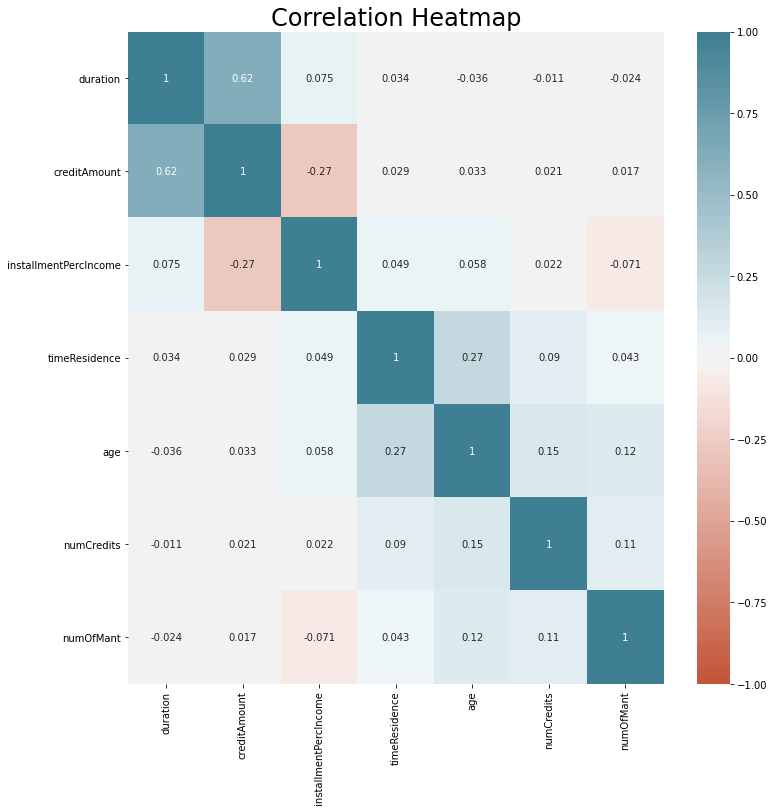

In [8]:
numerical = df.select_dtypes(include=['int64'])
numerical = (numerical-numerical.mean())/numerical.std()
corr = numerical.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, annot = True, 
            vmin = -1, vmax = 1, center = 0,
            cmap = sns.diverging_palette(20, 220, n = 200))
plt.title('Correlation Heatmap', fontsize = 24)

The correlation map shows that, as expected, the highest correlation is the one between duration and creditAmount; there are not other important correlations

## Categorical Data

To analize categorical data it is possible to use the plot of frequencies:

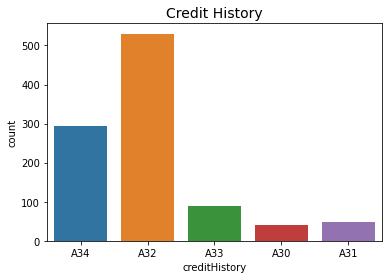

In [9]:
sns.countplot('creditHistory', data=df)
plt.title('Credit History', fontsize=14)
plt.show()

Credit history

*    A30 : no credits taken/ all credits paid back duly
*    A31 : all credits at this bank paid back duly
*    A32 : existing credits paid back duly till now
*    A33 : delay in paying off in the past
*    A34 : critical account/ other credits existing (not at this bank)

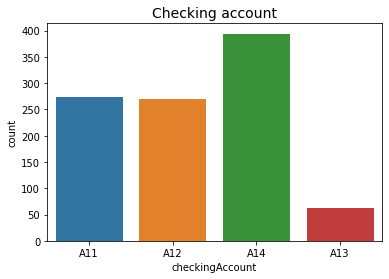

In [10]:
sns.countplot('checkingAccount', data=df)
plt.title('Checking account', fontsize=14)
plt.show()

Status of existing checking account
* A11 : ... < 0 DM
* A12 : 0 <= ... < 200 DM
* A13 : ... >= 200 DM / salary assignments for at least 1 year
* A14 : no checking account

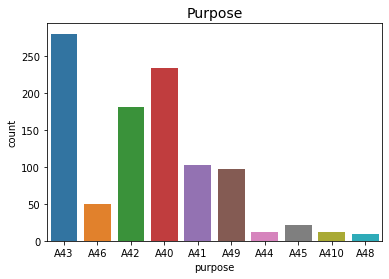

In [11]:
sns.countplot('purpose', data=df)
plt.title('Purpose', fontsize=14)
plt.show()

Purpose
* A40 : car (new)
* A41 : car (used)
* A42 : furniture/equipment
* A43 : radio/television
* A44 : domestic appliances
* A45 : repairs
* A46 : education
* A47 : (vacation - does not exist?)
* A48 : retraining
* A49 : business
* A410 : others

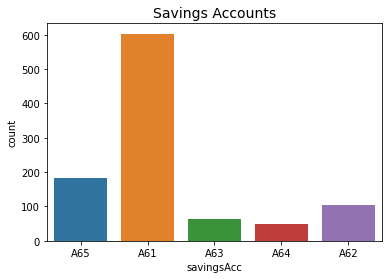

In [12]:
sns.countplot('savingsAcc', data=df)
plt.title('Savings Accounts', fontsize=14)
plt.show()

Savings account/bonds
* A61 : ... < 100 DM
* A62 : 100 <= ... < 500 DM
* A63 : 500 <= ... < 1000 DM
* A64 : .. >= 1000 DM
* A65 : unknown/ no savings account


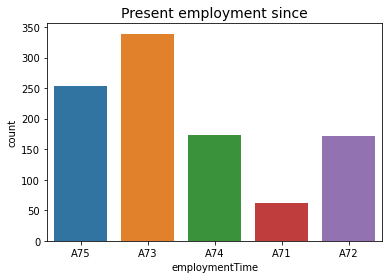

In [13]:
sns.countplot('employmentTime', data=df)
plt.title('Present employment since', fontsize=14)
plt.show()

Present employment since
* A71 : unemployed
* A72 : ... < 1 year
* A73 : 1 <= ... < 4 years
* A74 : 4 <= ... < 7 years
* A75 : .. >= 7 years

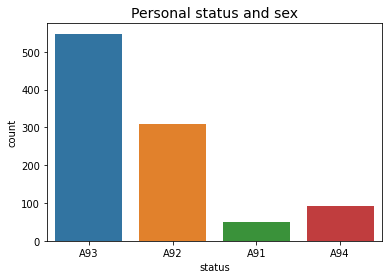

In [14]:
sns.countplot('status', data=df)
plt.title('Personal status and sex', fontsize=14)
plt.show()

Personal status and sex
* A91 : male : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male : single
* A94 : male : married/widowed
* A95 : female : single

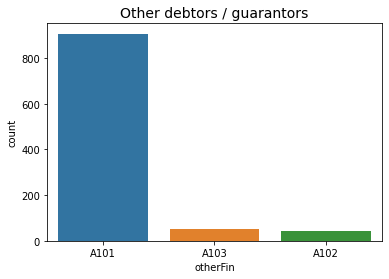

In [15]:
sns.countplot('otherFin', data=df)
plt.title('Other debtors / guarantors', fontsize=14)
plt.show()

Other debtors / guarantors
* A101 : none
* A102 : co-applicant
* A103 : guarantor 


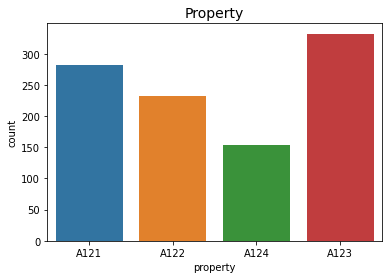

In [16]:
sns.countplot('property', data=df)
plt.title('Property', fontsize=14)
plt.show()

Property
* A121 : real estate
* A122 : if not A121 : building society savings agreement/ life insurance
* A123 : if not A121/A122 : car or other, not in attribute 6
* A124 : unknown / no property


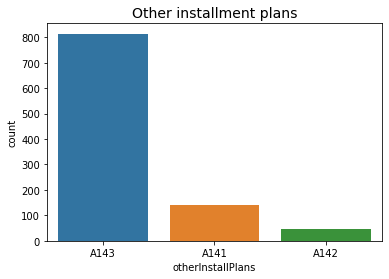

In [17]:
sns.countplot('otherInstallPlans', data=df)
plt.title('Other installment plans', fontsize=14)
plt.show()

Other installment plans
* A141 : bank
* A142 : stores
* A143 : none

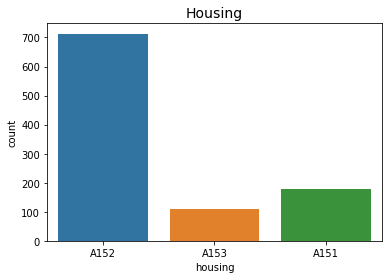

In [18]:
sns.countplot('housing', data=df)
plt.title('Housing', fontsize=14)
plt.show()

Housing
* A151 : rent
* A152 : own
* A153 : for free

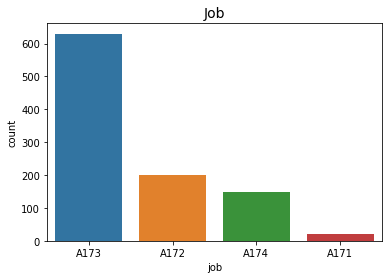

In [19]:
sns.countplot('job', data=df)
plt.title('Job', fontsize=14)
plt.show()

Job
* A171 : unemployed/ unskilled - non-resident
* A172 : unskilled - resident
* A173 : skilled employee / official
* A174 : management/ self-employed/highly qualified employee/ officer

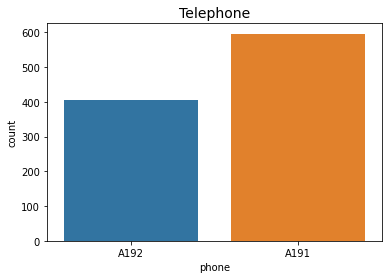

In [20]:
sns.countplot('phone', data=df)
plt.title('Telephone', fontsize=14)
plt.show()

Telephone
* A191 : none
* A192 : yes, registered under the customers name

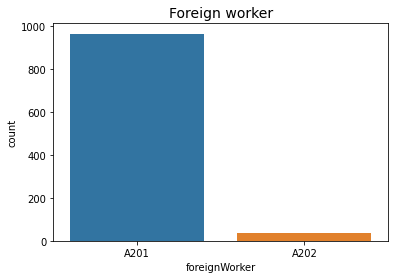

In [21]:
sns.countplot('foreignWorker', data=df)
plt.title('Foreign worker', fontsize=14)
plt.show()

Foreign worker
* A201 : yes
* A202 : no

From these plots, nothing of relevant has been detected.
Let's take a look to the frequency plot for the risk value:

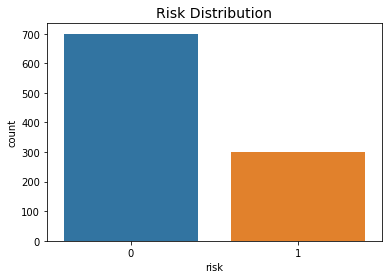

In [22]:
sns.countplot('risk', data=df)
plt.title('Risk Distribution', fontsize=14)
plt.show()

As said before, the 2 categories are not perfectly balanced.
Different approaches can be selected now. Let's take a look to outliers and other aspects of raw data, and then we will face this aspect.

## Distribution and Outliers

The numerical attributes in German Credit Risk data have many outliers. Some plot can help to understand:

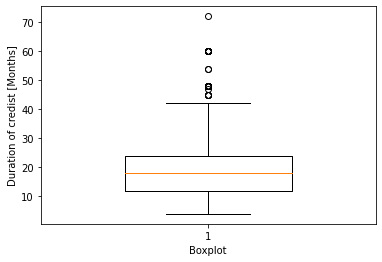

In [23]:
plt.boxplot(df['duration'], widths = 0.5)
plt.ylabel('Duration of credist [Months]')
plt.xlabel('Boxplot')
plt.show()

The average value for the duration of credits is 20 months, but some values are higher that 50. We can go deep and see if these values are trusted:

In [24]:
df[ df['duration'] > 50]

,checkingAccount,duration,creditHistory,purpose,creditAmount,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,timeResidence,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker,risk
29,A11,60,A33,A49,6836,A61,A75,3,A93,A101,4,A124,63,A143,A152,2,A173,1,A192,A201,1
78,A14,54,A30,A41,9436,A65,A73,2,A93,A101,2,A122,39,A143,A152,1,A172,2,A191,A201,0
95,A12,54,A30,A49,15945,A61,A72,3,A93,A101,4,A124,58,A143,A151,1,A173,1,A192,A201,1
134,A14,60,A32,A43,10144,A62,A74,2,A92,A101,4,A121,21,A143,A152,1,A173,1,A192,A201,0
255,A12,60,A33,A43,7418,A65,A73,1,A93,A101,1,A121,27,A143,A152,1,A172,1,A191,A201,0
332,A12,60,A32,A40,7408,A62,A72,4,A92,A101,2,A122,24,A143,A152,1,A174,1,A191,A201,1
373,A14,60,A34,A40,13756,A65,A75,2,A93,A101,4,A124,63,A141,A153,1,A174,1,A192,A201,0
374,A12,60,A31,A410,14782,A62,A75,3,A92,A101,4,A124,60,A141,A153,2,A174,1,A192,A201,1
616,A12,60,A33,A43,9157,A65,A73,2,A93,A101,2,A124,27,A143,A153,1,A174,1,A191,A201,0
637,A14,60,A33,A43,15653,A61,A74,2,A93,A101,4,A123,21,A143,A152,2,A173,1,A192,A201,0


We can see that there is not a recurrent pattern in this data, so we have no reasons to don't trust it.

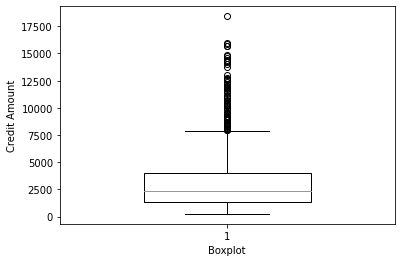

In [25]:
plt.boxplot(df['creditAmount'], widths = 0.5)
plt.ylabel('Credit Amount')
plt.xlabel('Boxplot')
plt.show()

In [26]:
df[ df['creditAmount'] > 7500].set_index(['risk','creditAmount', 'duration']).count(level="risk")

,checkingAccount,creditHistory,purpose,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,timeResidence,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker
risk,,,,,,,,,,,,,,,,,,
0,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
1,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44


## Correlations

Starting from the informations taked out from the heat map, we want to go deep into the analisys of them, in order to decide if some values can be dropped out from the dataset:

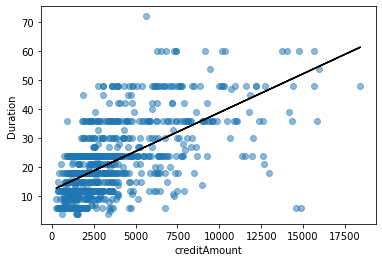

In [27]:
x = df['creditAmount']
y = df['duration']
plt.scatter(x, y, alpha=0.5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"black")
plt.xlabel('creditAmount')
plt.ylabel('Duration')
plt.show()

As expected, the number of rates and the amount of credit are positivly correlated. But we can see different elements that have a high variance, so we cannot drop out one of the attributes as if has been completly represented by the other one

# Data Preparation

## One hot Encoding

Apart from the target variabile, the dataset we use has now 7 numerical features and 13 categorical feature. Two of them are binary values, the others are nominal ones.

There is something to do in order to work with the nominal values. 
One approach can be to map it into numerical value; so each level of a categorical feature corresponds to an integer value.
The problem is that numerical values implies an order, but for our data this is not the correct approach.
To overcame this problem, the most commonly technique used is one hot encoding. Each category value is converted into a new column: we assign 1 to the corresponding value and 0 to everything else.
Let's look what happens in this case:

In [28]:
categorical = ['checkingAccount', 'creditHistory', 'purpose', 'savingsAcc', 'employmentTime', 'status', 'otherFin', 'property', 'otherInstallPlans', 'housing', 'job']

In [29]:
Y = df['risk'].copy()
oneHotDF = df.copy()
oneHotDF.drop(['risk'],axis=1, inplace=True)

for att in categorical:
  oneHotDF = pd.concat([oneHotDF,pd.get_dummies(oneHotDF[att], prefix = att)], axis=1)
  oneHotDF .drop([att],axis=1, inplace=True)
oneHotDF

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant,phone,foreignWorker,checkingAccount_A11,checkingAccount_A12,checkingAccount_A13,checkingAccount_A14,creditHistory_A30,creditHistory_A31,creditHistory_A32,creditHistory_A33,creditHistory_A34,purpose_A40,purpose_A41,purpose_A410,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,savingsAcc_A61,savingsAcc_A62,savingsAcc_A63,savingsAcc_A64,savingsAcc_A65,employmentTime_A71,employmentTime_A72,employmentTime_A73,employmentTime_A74,employmentTime_A75,status_A91,status_A92,status_A93,status_A94,otherFin_A101,otherFin_A102,otherFin_A103,property_A121,property_A122,property_A123,property_A124,otherInstallPlans_A141,otherInstallPlans_A142,otherInstallPlans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,1,A192,A201,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,A191,A201,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,A191,A201,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,A191,A201,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,A191,A201,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,A191,A201,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
996,30,3857,4,4,40,1,1,A192,A201,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,A191,A201,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
998,45,1845,4,4,23,1,1,A192,A201,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


Binary categorical features can be mapped as 0-1 variables:

In [30]:
phoneMapping = {
    'A191' : 1,
    'A192' : 0
}

foreignWorkerMapping = {
    'A202' : 1,
    'A201' : 0
}
oneHotDF['phone'] = oneHotDF['phone'].map(phoneMapping)
oneHotDF['foreignWorker'] = oneHotDF['foreignWorker'].map(foreignWorkerMapping)

In [31]:
oneHotDF

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant,phone,foreignWorker,checkingAccount_A11,checkingAccount_A12,checkingAccount_A13,checkingAccount_A14,creditHistory_A30,creditHistory_A31,creditHistory_A32,creditHistory_A33,creditHistory_A34,purpose_A40,purpose_A41,purpose_A410,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,savingsAcc_A61,savingsAcc_A62,savingsAcc_A63,savingsAcc_A64,savingsAcc_A65,employmentTime_A71,employmentTime_A72,employmentTime_A73,employmentTime_A74,employmentTime_A75,status_A91,status_A92,status_A93,status_A94,otherFin_A101,otherFin_A102,otherFin_A103,property_A121,property_A122,property_A123,property_A124,otherInstallPlans_A141,otherInstallPlans_A142,otherInstallPlans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
996,30,3857,4,4,40,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
998,45,1845,4,4,23,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


The one-hot-encoding procedure is necessary, but we can see that it has create a dataframe having three times the number of columns than the initial one. 


## PCA

The PCA (Principal Components Analysis) is a tecnique of dimensionality reduction, based on the idea of preserve the highest variance among the data but reducing the number of features.

Principal component are a new coordinate system. Given data on D variables, the hope is that the data points will lie mainly in a linear subspace of dimension d < D.
The PCs decompose the total variance of the data, so the sum of the variance among all the PCs corresponds to the total variance among original data.

The first PCs is the one which have the higher variance, the last PCs is the one having lower variance.

Each PC is an ortogonal linear transformation of the original data.


In [32]:
X_pca = oneHotDF.copy()
# Normalize:
X_pca_norm = (X_pca-X_pca.mean())/X_pca.std()
print("There are " + ("some" if X_pca_norm.isnull().values.any() else "no")  + " null/missing values in the dataset.")

There are no null/missing values in the dataset.


Text(0, 0.5, 'Variance explained')

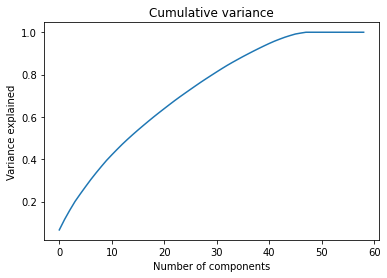

In [33]:
# calculate the principal components
X_pca = PCA(random_state = SEED).fit(X_pca_norm)
cumvar = np.cumsum(X_pca.explained_variance_ratio_)
#Plotting cumulative variance
plt.plot(cumvar)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [34]:
cumvar[35]

0.8850792991002365

In [35]:
n_used = 35
X_pca = np.dot(X_pca_norm.values, X_pca.components_[:n_used,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(n_used)])
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1.082157,-3.197403,1.416799,-2.128576,0.794921,-0.032605,-0.021152,-0.104399,1.391877,-0.485826,1.309274,-0.157171,-0.812471,1.065436,0.652970,-1.404743,0.698282,-0.250057,0.803691,1.843718,-0.218453,-1.247701,0.172129,-0.167908,0.259076,-0.850239,0.514253,-0.721604,-0.165025,-0.149025,-0.320648,-0.054975,1.363490,-0.330293,-0.844084
1,-2.046062,1.181714,-1.460144,1.090682,0.986275,0.073940,0.824098,0.083795,-0.873888,-1.949324,-0.569196,0.387994,-0.794746,-0.452731,-0.808203,0.248107,1.130982,-0.295376,1.417432,0.238133,0.145244,-0.151891,-0.086377,-0.152218,0.862216,-1.844986,-0.568349,-0.061486,-0.095967,0.726449,-0.173887,0.472890,0.432070,-0.230725,-0.391088
2,0.043917,-2.317239,2.305621,-0.914054,-1.172443,-0.329090,0.427019,-0.464922,-1.435776,0.389333,-0.861282,-1.476623,0.420367,-1.869308,-0.964124,1.889132,-0.303784,-0.111125,1.707624,-1.588365,-1.265883,0.020359,-0.233063,0.450322,-1.759031,0.688406,1.459506,-0.497424,0.725172,-0.507362,-1.045211,2.010000,1.738597,-0.101321,-0.234409
3,1.187569,2.782986,2.257115,-0.116350,4.270613,1.934985,-0.088762,-0.443202,-1.152752,2.655444,0.878449,-0.323830,-0.267440,-0.922543,0.181592,-0.308483,-0.082768,0.081125,1.961554,-2.347813,-0.221533,-0.682695,-1.155530,-1.142687,-0.348207,-0.143454,-1.016785,0.442327,0.612784,-0.155964,0.221144,-0.315698,0.236581,-0.378430,0.183735
4,3.320006,0.783071,1.719462,-1.520643,0.621341,1.081563,-0.930741,-1.235018,-3.484279,-0.972879,-0.402520,1.300858,0.836320,-0.721601,0.446074,0.315107,-0.168726,-0.771486,-0.679625,1.102042,-0.108621,0.360321,-1.099029,-1.384993,-0.948545,-1.299154,0.108081,1.376801,-0.246205,1.513928,0.396242,-1.092485,-0.486634,-0.607261,0.491395


In [36]:
Y.head()

0    0
1    1
2    0
3    0
4    1
Name: risk, dtype: category
Categories (2, int64): [0, 1]

### Train and Test set for PCA model

In order to create a learning algorith able to classify instances, we need to create a training set $S$, sampled from the entire dataset $D$, and to train our model triyng to minimize the training error.
This approach is based on the *Empirical Risk Minimization paradigm*, a learning paradigm that starts from the idea that, if S is representative of $D$, minimizing the error on $S$ we are also minimizing the error on $D$.
Let's define the error on $S$, given an hypotesis $h$, as:\
$$ L_s(h) =\frac{ \{ |i  \in [m] : h(x_i) \ne y_i   \}  }{m} $$
where:
*  $m$ is the training size
*  $h(x_i)$ is the predicted label
*  $y_i$ is the true label

At each step $i$, the loss is calculated and the hypotesis $h$ is changed in order to minimize $L_s(h)$.

In order to create a training set $S$ that represent the entire set $D$, let's define a set that preserve the proportionality among classes (defined by the parameter *stratify*). 

Then, the algorithm trained so far will be tested on the other part of the dataset $D$, the test set.

To approach our problem in this way, however, we need to manually select each algorithm that we want to analyze.
In order to choose the best algorithm (refering to the algorithm itself or the tuned hyperparameters of the algorithm), we need to do a *model selection*: by looking at all the hypothesis $h$, we want the one that best performs on our data.

A very accurate estimation of the true risk can be obtained using both train and validation set: the first for constructing the model and the second to select the best model among all the proposed.

Validation can be naturally used for model selection as follows:
* train the algorith on the training set and construct $H = {h_1,...,h_d}$
* choose a single predictor $h_s$ from $H$: the one that minimizes the error over the validation set
* use $h_s$ on the test set

In other words, we are applying a *ERM* approach to the validation set instead of to the training set.

In [37]:
X, X_test, y, y_test = train_test_split(X_pca, Y, test_size=0.3, stratify = Y)
X_val, X_train, y_val, y_train = train_test_split(X, y, test_size=0.57, stratify = y)

### Data Augmentation

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

This is a simple and effective strategy for imbalanced classification problems.

The dataset that we are analyzing are not really imbalanced; as we can see in the next box, the proportion between two categories is 7:3:

In [38]:
df['risk'].value_counts()

0    700
1    300
Name: risk, dtype: int64

But it could be intresting to ses a comparization of the performances of different classifiers between the original dataset and an oversampled-one, more balanced that the current one.

In [39]:
X_ADASYN, y_ADASYN = ADASYN().fit_resample(X_train, y_train)
print("Oversampling on X generate a dataset of ", X_ADASYN.shape, "istances, while the original dataset had ", X_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(y_ADASYN == 0), 'elements for riks = good, and', np.count_nonzero(y_ADASYN == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (525, 35) istances, while the original dataset had  (399, 35)  instances
The new dataset has 279 elements for riks = good, and 246 elements for riks = bad


In [40]:
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train, y_train)
print("Oversampling on X generate a dataset of ", X_SMOTE.shape, "istances, while the original dataset had ", X_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(y_SMOTE == 0), 'elements for riks = good, and', np.count_nonzero(y_SMOTE == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (558, 35) istances, while the original dataset had  (399, 35)  instances
The new dataset has 279 elements for riks = good, and 279 elements for riks = bad


So we can apply different classification algorithms both to **X**, **X_ADASYN** and **X_SMOTE** and find the one that has the best performance.

## Features Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model.
It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

By looking at our dataset, we can see that we have both qualitative and quantitative predictors

So we can use an ***Anova F-Test*** test in order to select the best features.


In [41]:
kbest = SelectKBest(f_classif)

### K-fold Cross Validation

In the PCA approach, select the number of selected PC for the model is easy: by looking at the cumulative variances we have an immediate way to evaluate how good the model is.

But, in features selection, there is a different approach:
we need to set a priori the hyperparameter K and we can evaluate how good the model performs only when the classification models gives its results.

And also the hyperparametes of the classification models need to be tuned. So, at each step, we need to define both K and model hyperparameters.


A good approach, in this case, can be to use a K_Fold Cross-Validation model:
the original dataset is divided in $k$ partitions having $\frac{n}{k}$ elements, where $n$ is the size of the original dataset.
At each step, the $i^{th}$ partition is used as training set and the others $k - 1$ are concatenated and used as validation set.
The model is trained on the training set, and validate on the validation set and the final score for the model is the average mean squared error:\
$CV_{(k)} = \frac{1}{k} \cdot \sum_{i = 1}^{k} {MSE_i}$, where $MSE_i = | Y_i - \hat{Y_i} |^2$ \
being $\hat{Y_i}$ the predictor of $Y_i$ using all the other observations.

At each of the $k$ iterations, the model uses a different set of parameters and, finally, the model providing the best score is selected as the best one and the entire dataset is re-trained by using those hyperparameters.

In [42]:
Xfs = oneHotDF.copy()
Xfs_train, Xfs_test, yfs_train, yfs_test = train_test_split(Xfs, Y, test_size=0.3, stratify = Y)

### Data Augmentation

The same approach used for the PCA section is used here:

In [43]:
Xfs_ADASYN, yfs_ADASYN = ADASYN().fit_resample(Xfs_train, yfs_train)
print("Oversampling on X generate a dataset of ", Xfs_ADASYN.shape, "istances, while the original dataset had ", Xfs_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(yfs_ADASYN == 0), 'elements for riks = good, and', np.count_nonzero(yfs_ADASYN == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (995, 59) istances, while the original dataset had  (700, 59)  instances
The new dataset has 490 elements for riks = good, and 505 elements for riks = bad


In [44]:
Xfs_SMOTE, yfs_SMOTE = SMOTE().fit_resample(Xfs_train, yfs_train)
print("Oversampling on X generate a dataset of ", Xfs_SMOTE.shape, "istances, while the original dataset had ", Xfs_train.shape, " instances")
print( 'The new dataset has' , np.count_nonzero(yfs_SMOTE == 0), 'elements for riks = good, and', np.count_nonzero(yfs_SMOTE == 1), 'elements for riks = bad')

Oversampling on X generate a dataset of  (980, 59) istances, while the original dataset had  (700, 59)  instances
The new dataset has 490 elements for riks = good, and 490 elements for riks = bad


# Classification Algorithms

After having defined all the different datasets, let's start with the classification task: this is the problem of assigning a category to each item.

In order to compare models and find the one that performs better, it's needed to define which metrics will be used to evaluate performances.

Let: $TP$ = True positives, $TN$ = True negative, $FP$ = False positive, $FN$ = False negative.

Accuracy = $\frac{TP + TN}{TP+TN + FP + FN} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$

Precision = $\frac{\text{TP}}{\text{TP + FP}}$

Sensitivity = $\frac{\text{TP}}{\text{TP + FN}}$


F1 Score = $2 \cdot \frac{\text{Precision}\cdot \text{Sensitivity}}{\text{Precision + Sensitivity}} $




In [45]:
binary_metricsPCA = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])
binary_metricsFS = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])
binary_metricsORIG = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])

## Theory overview

### SVM Method

The basic Support-Vector Machine (SVM) model is linear: it finds the optimal hyperplane between the points of two classes such that the distance of the nearest points to the decision boundary is maximized.

Clearly, it is not common to have a linear separation and SVM can be generalized.

This generalization can be made by choosing a non-linear Kernel function to apply to the support vector machine.

Linear support vector machine generally uses as linear kernel:$$ k({\vec{x_i}},{\vec{x_{j}}})={\vec{x_{i}}}\cdot{\vec{x_{j}}}$$

Probably the common non-lineare alternative is the Radial basis kernel:$${k({\vec{x_i},\vec{x_{j}}})=\exp(-\gamma \|{\vec {x_{i}}}-{\vec {x_{j}}}\|^{2})}$$where $\gamma \gt0$ is a parameter to chose. This is in fact the default kernel function in the library.

Basically, the kernel maps the data into another space in which the class can be linearly separated, while in the original space, the boundary will in general be non linear.

### KNN Method

K-Nearest-Neighbors is one of the simplest classification algorithm in supervised learning. The core idea for KNN is that the features that are used to describe the domain points determinates their classification label. So, features from the same classes need to have similar features. But if we project the domain points in the hyper-space of the features, elements with similar features (and so belonging to the same class) are closer one to each other.
So, the KNN algorithm assigned to a point the label of the closest point(s).
This algorithm has onehyper-parameter:  the value of $k$, that define the number of neighbors to consider in order to have the classification: $k \in \mathbb{N}$.

$k$ must be an odd number in order to avoid uncertain classification in case of binary classification.

The concept of "close" is related to the concept of distance. KNN algorithm use an Euclidean Distances defined as:

$\rho(x, x') = || x - x' || = \sqrt{ \sum_{i=1}^{d}{(x_i - x_i')^2}}$

### Logistic Regression Method

The logistic regression in a generalization of linear regression that allow to solve binary classification problems. In order to execute this generalization, the steps are:
* substitute the normal distribution for error with a Bernoulli Distribution:
$p(y|\hat{x},\hat{w}) = Ber(y| \mu(\hat{x}) ) $, where $\mu(x)$ = $p(y=1| \hat{x})$
* coumpute a linear combination of inputs in order to be shure that $0 \leq \mu({\hat{x}}) \leq 1$ by using a **sigmoid**, that has the following shape:

![Sigmoid function](https://upload.wikimedia.org/wikipedia/commons/5/53/Sigmoid-function-2.svg)



### Decision Trees

A decision tree is a predictor $h : H \to Y$, that predicts the label associated to an instance of $x$ by travelling from the root to the leaf of a tree in which nodes represent features and edges are values.

Usually the decision tree learning algorithm are based on a greedy approach: the tree is constructed gradually and at each step the decision is taken by analize the local optimal decision. So it's not guarantee a global optimal tree.

The model starts with a single leaf, the root. The leaf recives as lable the one according to the majority vote among all labels over the training set. Then, in a set of iterations, the algorithm examinates the possibility of split each leaf and evaluate the gain in splitting it.
Among all the possibile splits, the one that gave the best gain is choosen

## PCA

In [46]:
PCAparams = {
    'SVM' : {'C' : np.logspace(0, 4, 5) },
    'KNN' : {'n_neighbors' : [5,7,9,11] },
    'LR' : {'solver' : ['newton-cg', 'lbfgs', 'liblinear'] },
    'GiniTREE' : {'max_depth': np.arange(5, 20) }
}

PCAmethods = {
    'SVM' : svm.SVC(kernel = "rbf", random_state = SEED),
    'KNN' : KNeighborsClassifier(),
    'LR' :  LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs'),
    'GiniTREE' : DecisionTreeClassifier(criterion = 'gini', random_state = SEED)
}

In [47]:
def TrainFunction(methodName, paramName, dataset = 'original'):
  scaler = StandardScaler()
  if( dataset == 'original'):
    scal_X_train = scaler.fit_transform(X_train)
    x_train = scal_X_train
    Y = y_train
  elif( dataset == 'adasyn'):
    scal_X_train = scaler.fit_transform(X_ADASYN)
    x_train = scal_X_train
    Y = y_ADASYN
  elif( dataset == 'smote'):
    scal_X_train = scaler.fit_transform(X_SMOTE)
    x_train = scal_X_train
    Y = y_SMOTE
  
  method = PCAmethods[methodName]
  best_score = 0

  for p in PCAparams[methodName].get(paramName):
    params = { paramName : p}
    model = method.set_params(**params).fit(x_train, Y)
    y_pred = model.predict(X_val)

    cr = classification_report(y_val, y_pred, output_dict=True)
    #print('Accuracy for', paramName, ' = ', p, ' = ',cr['accuracy'])
    #print('Weighted precision = ', cr['weighted avg'])
    if( cr['weighted avg']['f1-score'] > best_score):
      best_score = cr['weighted avg']['f1-score']
      bestP = p

  params = { paramName : bestP}
  newX_train = np.concatenate( (x_train, X_val), axis=0)
  newY_train = np.concatenate( (Y, y_val), axis=0)
  model = method.set_params(**params).fit(newX_train, newY_train)

  y_pred = model.predict(X_test)
  cr = classification_report(y_test, y_pred, output_dict=True)
  binary_metricsPCA.loc[dataset + '_' + methodName] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy for', paramName, ' = ', bestP, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

In [48]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth']
for name, paramName in zip(algs, paramNames):
  TrainFunction( name, paramName)

Accuracy for C  =  1.0  =  0.77
Weighted precision =  {'precision': 0.7635294117647059, 'recall': 0.77, 'f1-score': 0.7427956989247311, 'support': 300}
Accuracy for n_neighbors  =  9  =  0.74
Weighted precision =  {'precision': 0.7219269102990034, 'recall': 0.74, 'f1-score': 0.706060606060606, 'support': 300}
Accuracy for solver  =  newton-cg  =  0.78
Weighted precision =  {'precision': 0.7731808731808731, 'recall': 0.78, 'f1-score': 0.7751984126984126, 'support': 300}
Accuracy for max_depth  =  7  =  0.6866666666666666
Weighted precision =  {'precision': 0.671537909591007, 'recall': 0.6866666666666666, 'f1-score': 0.6771313492951443, 'support': 300}


In [49]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth']
for name, paramName in zip(algs, paramNames):
  TrainFunction( name, paramName, dataset = 'adasyn')

Accuracy for C  =  1.0  =  0.7466666666666667
Weighted precision =  {'precision': 0.7304166666666667, 'recall': 0.7466666666666667, 'f1-score': 0.7297777777777777, 'support': 300}
Accuracy for n_neighbors  =  11  =  0.6566666666666666
Weighted precision =  {'precision': 0.685475910693302, 'recall': 0.6566666666666666, 'f1-score': 0.6667366471133065, 'support': 300}
Accuracy for solver  =  newton-cg  =  0.6933333333333334
Weighted precision =  {'precision': 0.7269444444444444, 'recall': 0.6933333333333334, 'f1-score': 0.7034432234432235, 'support': 300}
Accuracy for max_depth  =  5  =  0.64
Weighted precision =  {'precision': 0.6657864741641337, 'recall': 0.64, 'f1-score': 0.6496542116523212, 'support': 300}


In [50]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth']
for name, paramName in zip(algs, paramNames):
  TrainFunction( name, paramName, dataset = 'smote')

Accuracy for C  =  1.0  =  0.74
Weighted precision =  {'precision': 0.7247086247086247, 'recall': 0.74, 'f1-score': 0.727027027027027, 'support': 300}
Accuracy for n_neighbors  =  11  =  0.67
Weighted precision =  {'precision': 0.7167278661770706, 'recall': 0.67, 'f1-score': 0.6824937978643081, 'support': 300}
Accuracy for solver  =  newton-cg  =  0.67
Weighted precision =  {'precision': 0.7195763132932833, 'recall': 0.67, 'f1-score': 0.6827612555068708, 'support': 300}
Accuracy for max_depth  =  5  =  0.6633333333333333
Weighted precision =  {'precision': 0.6753719090502015, 'recall': 0.6633333333333333, 'f1-score': 0.668500620847681, 'support': 300}


In [51]:
binary_metricsPCA

,Accuracy,Precision,Sensitivity,F1 Score
original_SVM,0.770000,0.763529,0.770000,0.742796
original_KNN,0.740000,0.721927,0.740000,0.706061
original_LR,0.780000,0.773181,0.780000,0.775198
original_GiniTREE,0.686667,0.671538,0.686667,0.677131
adasyn_SVM,0.746667,0.730417,0.746667,0.729778
adasyn_KNN,0.656667,0.685476,0.656667,0.666737
adasyn_LR,0.693333,0.726944,0.693333,0.703443
adasyn_GiniTREE,0.640000,0.665786,0.640000,0.649654
smote_SVM,0.740000,0.724709,0.740000,0.727027
smote_KNN,0.670000,0.716728,0.670000,0.682494


## Features Selection

In [52]:
kBestList = [30,40,50]

FSsteps = {
    'SVM' : [('kbest', kbest), ('scaler', StandardScaler()), ('SVM', svm.SVC(kernel = "rbf", random_state = SEED))],
    'KNN' : [('kbest', kbest), ('scaler', StandardScaler()), ('KNN', KNeighborsClassifier()) ],
    'LR' : [('kbest', kbest), ('scaler', StandardScaler()), ('LR', LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs') ) ],
    'GiniTREE' : [('kbest', kbest), ('scaler', StandardScaler()), ('GiniTREE', DecisionTreeClassifier(criterion = 'gini', random_state = SEED) ) ]
}

FSparams = {
    'SVM' : {'SVM__C' : np.logspace(0, 4, 5), 'kbest__k': kBestList },
    'KNN' : {'KNN__n_neighbors' : [5, 7, 9, 11], 'kbest__k': kBestList},
    'LR' : {'LR__solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'kbest__k': kBestList},
    'GiniTREE' : {'GiniTREE__max_depth': np.arange(5, 20), 'kbest__k': kBestList }
}


In [53]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE']

In [54]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_train, yfs_train)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['original' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])
   

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 50}
Accuracy with  SVM  =  0.7166666666666667
Weighted precision =  {'precision': 0.7074574717910532, 'recall': 0.7166666666666667, 'f1-score': 0.7110613819519762, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 5, 'kbest__k': 40}
Accuracy with  KNN  =  0.7333333333333333
Weighted precision =  {'precision': 0.7138785978911371, 'recall': 0.7333333333333333, 'f1-score': 0.7139440325281033, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'liblinear', 'kbest__k': 40}
Accuracy with  LR  =  0.7533333333333333
Weighted precision =  {'precision': 0.7397824397824397, 'recall': 0.7533333333333333, 'f1-score': 0.741025641025641, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 14, 'kbest__k': 50}
Accuracy with  GiniTREE  =  0.67
Weighted precision =  {'precision': 0.6627671978235522, 'recall': 0.67, 'f1-score': 0.6660286174547522, 'support': 300}


In [55]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_ADASYN, yfs_ADASYN)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['adasyn' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 30}
Accuracy with  SVM  =  0.7166666666666667
Weighted precision =  {'precision': 0.7090309487569761, 'recall': 0.7166666666666667, 'f1-score': 0.7121825542878174, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 11, 'kbest__k': 40}
Accuracy with  KNN  =  0.6933333333333334
Weighted precision =  {'precision': 0.710056409258899, 'recall': 0.6933333333333334, 'f1-score': 0.6997777328753283, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'newton-cg', 'kbest__k': 30}
Accuracy with  LR  =  0.73
Weighted precision =  {'precision': 0.7243295763699961, 'recall': 0.73, 'f1-score': 0.7267506870084336, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 8, 'kbest__k': 30}
Accuracy with  GiniTREE  =  0.6766666666666666
Weighted precision =  {'precision': 0.6928205128205128, 'recall': 0.6766666666666666, 'f1-score': 0.6831149097815764, 'support': 300}


In [56]:
for el in algs:
  steps = FSsteps[el]
  parameters = FSparams[el]
  pipeline = Pipeline(steps)
  grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring = 'f1')

  grid.fit(Xfs_SMOTE, yfs_SMOTE)
  print('For method', el, 'best parameters are: ', grid.best_params_)

  Yfs_pred = grid.predict(Xfs_test)
  cr = classification_report(yfs_test, Yfs_pred, output_dict=True)
  binary_metricsFS.loc['smote' + '_' + el] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy with ', el, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

For method SVM best parameters are:  {'SVM__C': 10.0, 'kbest__k': 40}
Accuracy with  SVM  =  0.7166666666666667
Weighted precision =  {'precision': 0.7106490478041197, 'recall': 0.7166666666666667, 'f1-score': 0.7132568937742823, 'support': 300}
For method KNN best parameters are:  {'KNN__n_neighbors': 7, 'kbest__k': 50}
Accuracy with  KNN  =  0.69
Weighted precision =  {'precision': 0.6795979151154132, 'recall': 0.69, 'f1-score': 0.6838671590768682, 'support': 300}
For method LR best parameters are:  {'LR__solver': 'liblinear', 'kbest__k': 40}
Accuracy with  LR  =  0.74
Weighted precision =  {'precision': 0.7325, 'recall': 0.74, 'f1-score': 0.7353761969904241, 'support': 300}
For method GiniTREE best parameters are:  {'GiniTREE__max_depth': 8, 'kbest__k': 30}
Accuracy with  GiniTREE  =  0.6433333333333333
Weighted precision =  {'precision': 0.6605860805860806, 'recall': 0.6433333333333333, 'f1-score': 0.650446343779677, 'support': 300}


In [57]:
binary_metricsFS

,Accuracy,Precision,Sensitivity,F1 Score
original_SVM,0.716667,0.707457,0.716667,0.711061
original_KNN,0.733333,0.713879,0.733333,0.713944
original_LR,0.753333,0.739782,0.753333,0.741026
original_GiniTREE,0.670000,0.662767,0.670000,0.666029
adasyn_SVM,0.716667,0.709031,0.716667,0.712183
adasyn_KNN,0.693333,0.710056,0.693333,0.699778
adasyn_LR,0.730000,0.724330,0.730000,0.726751
adasyn_GiniTREE,0.676667,0.692821,0.676667,0.683115
smote_SVM,0.716667,0.710649,0.716667,0.713257
smote_KNN,0.690000,0.679598,0.690000,0.683867


## Original Datased

In [58]:
Y_Orig = df['risk'].copy()
X_Orig = oneHotDF
X_Orig = (X_Orig-X_Orig.mean())/X_Orig.std()

In [59]:
X_Orig, X_Orig_test, Y_Orig, Y_Orig_test = train_test_split(X_Orig, Y_Orig, test_size=0.3, stratify = Y_Orig)
X_Orig_val, X_Orig_train, Y_Orig_val, Y_Orig_train = train_test_split(X_Orig, Y_Orig, test_size=0.57, stratify = Y_Orig)

In [60]:
ORIGparams = {
    'SVM' : {'C' : np.logspace(0, 4, 5) },
    'KNN' : {'n_neighbors' : [5,7,9,11] },
    'LR' : {'solver' : ['newton-cg', 'lbfgs', 'liblinear'] },
    'GiniTREE' : {'max_depth': np.arange(5, 20) }
}

ORIGmethods = {
    'SVM' : svm.SVC(kernel = "rbf", random_state = SEED),
    'KNN' : KNeighborsClassifier(),
    'LR' :  LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs'),
    'GiniTREE' : DecisionTreeClassifier(criterion = 'gini', random_state = SEED)
}

In [61]:
def TrainOrigFunction(methodName, paramName):
  method = ORIGmethods[methodName]
  best_score = 0

  for p in ORIGparams[methodName].get(paramName):
    params = { paramName : p}
    model = method.set_params(**params).fit(X_Orig_train, Y_Orig_train)
    y_pred = model.predict(X_Orig_val)

    cr = classification_report(Y_Orig_val, y_pred, output_dict=True)

    if( cr['weighted avg']['f1-score'] > best_score):
      best_score = cr['weighted avg']['f1-score']
      bestP = p

  params = { paramName : bestP}
  newX_train = np.concatenate( (X_Orig_train, X_Orig_val), axis=0)
  newY_train = np.concatenate( (Y_Orig_train, Y_Orig_val), axis=0)
  model = method.set_params(**params).fit(newX_train, newY_train)
  #if(methodName == 'GiniTREE'):
  #  fig, ax = plt.subplots(figsize=(12, 12))
  #  tree.plot_tree(model, max_depth=4, fontsize=10)
  y_pred = model.predict(X_Orig_test)
  cr = classification_report(Y_Orig_test, y_pred, output_dict=True)
  binary_metricsORIG.loc['orig' + '_' + methodName] = [cr['accuracy'], cr['weighted avg']['precision'], cr['weighted avg']['recall'], cr['weighted avg']['f1-score']]
  print('Accuracy for', paramName, ' = ', bestP, ' = ',cr['accuracy'])
  print('Weighted precision = ', cr['weighted avg'])

In [62]:
algs = ['SVM', 'KNN', 'LR', 'GiniTREE']
paramNames = ['C', 'n_neighbors', 'solver', 'max_depth']
for name, paramName in zip(algs, paramNames):
  TrainOrigFunction( name, paramName)

Accuracy for C  =  1.0  =  0.7533333333333333
Weighted precision =  {'precision': 0.7388888888888889, 'recall': 0.7533333333333333, 'f1-score': 0.7270092226613967, 'support': 300}
Accuracy for n_neighbors  =  11  =  0.7233333333333334
Weighted precision =  {'precision': 0.6972313777191826, 'recall': 0.7233333333333334, 'f1-score': 0.686043067107212, 'support': 300}
Accuracy for solver  =  newton-cg  =  0.74
Weighted precision =  {'precision': 0.7265838509316771, 'recall': 0.74, 'f1-score': 0.729659090909091, 'support': 300}
Accuracy for max_depth  =  6  =  0.67
Weighted precision =  {'precision': 0.64249547920434, 'recall': 0.67, 'f1-score': 0.6508487958941966, 'support': 300}


In [63]:
binary_metricsORIG

,Accuracy,Precision,Sensitivity,F1 Score
orig_SVM,0.753333,0.738889,0.753333,0.727009
orig_KNN,0.723333,0.697231,0.723333,0.686043
orig_LR,0.740000,0.726584,0.740000,0.729659
orig_GiniTREE,0.670000,0.642495,0.670000,0.650849


# Results

In this work, I've compared various algorithms and approaches to find out which was the best way to solve the classification problem.

The first thing to highlights is that apply a dataset reduction (both PCA and features selection) is been a good strategy: all the scores are positively affected by that.

The question that arose during the analysis of the distribution of the variable 'risk' (if in a dataset not excessively unbalanced can be a good idea do data augmentation), has not a real answer. 

It's clear that in this case, some models perform better with the original dataset and others with the augmented one. 
So, in a similar situation, the best solution is to try and test all the possibility and see which is the best in that specific case.

About classification models, we can see that Trees has always the worst performances; the reason might be that the dataset has not a defined pattern from the features to the output.

In [64]:
binary_metricsFS

,Accuracy,Precision,Sensitivity,F1 Score
original_SVM,0.716667,0.707457,0.716667,0.711061
original_KNN,0.733333,0.713879,0.733333,0.713944
original_LR,0.753333,0.739782,0.753333,0.741026
original_GiniTREE,0.670000,0.662767,0.670000,0.666029
adasyn_SVM,0.716667,0.709031,0.716667,0.712183
adasyn_KNN,0.693333,0.710056,0.693333,0.699778
adasyn_LR,0.730000,0.724330,0.730000,0.726751
adasyn_GiniTREE,0.676667,0.692821,0.676667,0.683115
smote_SVM,0.716667,0.710649,0.716667,0.713257
smote_KNN,0.690000,0.679598,0.690000,0.683867


In [65]:
binary_metricsPCA

,Accuracy,Precision,Sensitivity,F1 Score
original_SVM,0.770000,0.763529,0.770000,0.742796
original_KNN,0.740000,0.721927,0.740000,0.706061
original_LR,0.780000,0.773181,0.780000,0.775198
original_GiniTREE,0.686667,0.671538,0.686667,0.677131
adasyn_SVM,0.746667,0.730417,0.746667,0.729778
adasyn_KNN,0.656667,0.685476,0.656667,0.666737
adasyn_LR,0.693333,0.726944,0.693333,0.703443
adasyn_GiniTREE,0.640000,0.665786,0.640000,0.649654
smote_SVM,0.740000,0.724709,0.740000,0.727027
smote_KNN,0.670000,0.716728,0.670000,0.682494
